In [ ]:
# dataset download
!git clone https://github.com/bochendong/few_shot_classification.git

Cloning into 'few_shot_classification'...
remote: Enumerating objects: 13216, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 13216 (delta 31), reused 47 (delta 17), pack-reused 13152 (from 1)
Receiving objects: 100% (13216/13216), 437.31 MiB | 17.03 MiB/s, done.
Resolving deltas: 100% (487/487), done.
Updating files: 100% (29045/29045), done.


In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

In [ ]:
# Data paths
train_dir = '/content/few_shot_classification/code/train'
val_dir = '/content/few_shot_classification/code/val'

# Data transformations (image preprocessing)
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),          # Resize image
    transforms.RandomHorizontalFlip(),      # Random horizontal flip
    transforms.RandomRotation(15),         # Random rotation
    transforms.ToTensor(),                  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),          # Resize image
    transforms.ToTensor(),                  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load data using ImageFolder
train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = ImageFolder(root=val_dir, transform=val_transforms)

# Check class labels
print(f"Class labels: {train_dataset.classes}")  # Print list of class names

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

클래스 레이블: ['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk', 'Nidok

이미지 크기: torch.Size([32, 3, 128, 128]), 라벨: tensor([112,  81, 115,  97,  48, 139,  14,  97,  78, 103, 138,  56,  22, 121,
         86,  20, 106,  20, 116,  66,  63,  77,  25,  17, 137,  97,  96, 113,
        113,  41,  26,  79])


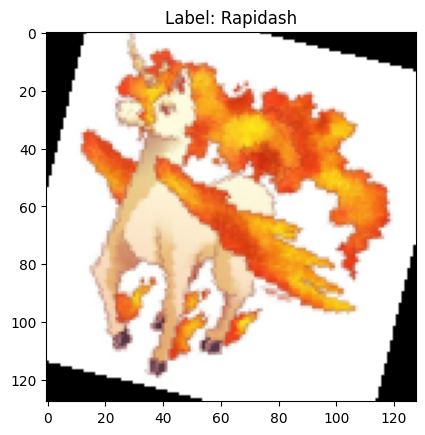

In [ ]:
from matplotlib import pyplot as plt

# 데이터 확인
imgs, labels = next(iter(train_loader))
print(f"이미지 크기: {imgs.shape}, 라벨: {labels}")

# 첫 번째 이미지 시각화
plt.imshow(imgs[0].permute(1, 2, 0) * 0.5 + 0.5)  # Normalize 해제
plt.title(f"Label: {train_dataset.classes[labels[0]]}")
plt.show()

In [ ]:
# Load data using ImageFolder
train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = ImageFolder(root=val_dir, transform=val_transforms)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Check classes
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Class names: {train_dataset.classes}")

# ========== 2. Model Preparation ==========
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load ResNet50 model
model = models.resnet50(weights="IMAGENET1K_V2").to(device)

# Modify the output layer: Add Dropout to the Fully Connected Layer
model.fc = nn.Sequential(
    nn.Linear(2048, 1024),        # 2048 -> 1024
    nn.ReLU(),                   # Activation function
    nn.Dropout(0.5),             # Apply Dropout
    nn.Linear(1024, num_classes) # 1024 -> Number of classes
).to(device)

# Check the model
print(model.fc)
# Modified output layer to fit the number of classes

# ========== 3. Loss Function and Optimizer ==========
criterion = nn.CrossEntropyLoss()  # Loss function suitable for classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Adam Optimizer
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Learning rate decay

# ========== 4. Training and Evaluation ==========
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_correct = 0, 0
    for imgs, labels in tqdm(loader, desc="Training"):
        imgs, labels = imgs.to(device), labels.to(device)

        # Forward pass
        logits = model(imgs)
        loss = criterion(logits, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate metrics
        total_loss += loss.item() * imgs.size(0)
        total_correct += (logits.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    avg_acc = total_correct / len(loader.dataset)
    return avg_loss, avg_acc

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Validating"):
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            loss = criterion(logits, labels)

            total_loss += loss.item() * imgs.size(0)
            total_correct += (logits.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    avg_acc = total_correct / len(loader.dataset)
    return avg_loss, avg_acc

클래스 수: 150
클래스 이름: ['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Mu

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s]


Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1024, out_features=150, bias=True)
)


In [ ]:
# ========== 5. Training Loop ==========
num_epochs = 50
best_acc = 0.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Training
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # Validation
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save the best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_resnet50.pth")
        print("Best model saved!")

    # Update scheduler
    scheduler.step()

print(f"Training completed! Best Validation Accuracy: {best_acc:.4f}")

Epoch 1/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 3.3540, Train Acc: 0.2589


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 2.0119, Val Acc: 0.4688
Best model saved!
Epoch 2/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 1.2680, Train Acc: 0.6484


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.9293, Val Acc: 0.7351
Best model saved!
Epoch 3/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.6905, Train Acc: 0.7939


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.6951, Val Acc: 0.8151
Best model saved!
Epoch 4/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.5423, Train Acc: 0.8453


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.7251, Val Acc: 0.8070
Epoch 5/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.4024, Train Acc: 0.8773


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.7331, Val Acc: 0.7916
Epoch 6/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.3886, Train Acc: 0.8866


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.5712, Val Acc: 0.8489
Best model saved!
Epoch 7/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.2924, Train Acc: 0.9152


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.5716, Val Acc: 0.8371
Epoch 8/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.2611, Train Acc: 0.9229


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.5354, Val Acc: 0.8679
Best model saved!
Epoch 9/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.2390, Train Acc: 0.9295


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.6334, Val Acc: 0.8393
Epoch 10/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.2250, Train Acc: 0.9314


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.4754, Val Acc: 0.8723
Best model saved!
Epoch 11/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0937, Train Acc: 0.9717


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.3085, Val Acc: 0.9252
Best model saved!
Epoch 12/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0476, Train Acc: 0.9861


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2904, Val Acc: 0.9296
Best model saved!
Epoch 13/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0341, Train Acc: 0.9908


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2795, Val Acc: 0.9310
Best model saved!
Epoch 14/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0340, Train Acc: 0.9902


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2784, Val Acc: 0.9340
Best model saved!
Epoch 15/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0216, Train Acc: 0.9940


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2836, Val Acc: 0.9288
Epoch 16/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0231, Train Acc: 0.9928


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2699, Val Acc: 0.9318
Epoch 17/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0172, Train Acc: 0.9940


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2662, Val Acc: 0.9332
Epoch 18/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0135, Train Acc: 0.9960


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2677, Val Acc: 0.9340
Epoch 19/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0150, Train Acc: 0.9947


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2844, Val Acc: 0.9318
Epoch 20/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0143, Train Acc: 0.9953


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2923, Val Acc: 0.9369
Best model saved!
Epoch 21/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0137, Train Acc: 0.9955


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2886, Val Acc: 0.9340
Epoch 22/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0109, Train Acc: 0.9970


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2857, Val Acc: 0.9376
Best model saved!
Epoch 23/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0125, Train Acc: 0.9960


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2912, Val Acc: 0.9318
Epoch 24/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0095, Train Acc: 0.9977


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2888, Val Acc: 0.9325
Epoch 25/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0129, Train Acc: 0.9962


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2887, Val Acc: 0.9347
Epoch 26/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0100, Train Acc: 0.9968


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2789, Val Acc: 0.9340
Epoch 27/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0085, Train Acc: 0.9981


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2839, Val Acc: 0.9391
Best model saved!
Epoch 28/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0118, Train Acc: 0.9968


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2931, Val Acc: 0.9347
Epoch 29/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0095, Train Acc: 0.9977


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2861, Val Acc: 0.9318
Epoch 30/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0113, Train Acc: 0.9966


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2785, Val Acc: 0.9340
Epoch 31/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0111, Train Acc: 0.9972


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2828, Val Acc: 0.9340
Epoch 32/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0083, Train Acc: 0.9979


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2845, Val Acc: 0.9362
Epoch 33/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0079, Train Acc: 0.9979


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2802, Val Acc: 0.9354
Epoch 34/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0085, Train Acc: 0.9972


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2850, Val Acc: 0.9340
Epoch 35/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0114, Train Acc: 0.9960


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2720, Val Acc: 0.9340
Epoch 36/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0075, Train Acc: 0.9977


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2818, Val Acc: 0.9369
Epoch 37/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0081, Train Acc: 0.9983


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2708, Val Acc: 0.9384
Epoch 38/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0104, Train Acc: 0.9970


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2812, Val Acc: 0.9384
Epoch 39/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0077, Train Acc: 0.9983


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2802, Val Acc: 0.9369
Epoch 40/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0085, Train Acc: 0.9970


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2788, Val Acc: 0.9354
Epoch 41/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0082, Train Acc: 0.9977


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2811, Val Acc: 0.9369
Epoch 42/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0098, Train Acc: 0.9964


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2788, Val Acc: 0.9362
Epoch 43/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0099, Train Acc: 0.9974


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2744, Val Acc: 0.9376
Epoch 44/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0090, Train Acc: 0.9979


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2771, Val Acc: 0.9384
Epoch 45/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0091, Train Acc: 0.9974


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2753, Val Acc: 0.9391
Epoch 46/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0094, Train Acc: 0.9972


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2772, Val Acc: 0.9398
Best model saved!
Epoch 47/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0098, Train Acc: 0.9974


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2836, Val Acc: 0.9376
Epoch 48/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0099, Train Acc: 0.9979


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2792, Val Acc: 0.9369
Epoch 49/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0080, Train Acc: 0.9981


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2870, Val Acc: 0.9340
Epoch 50/50


Training:   0%|          | 0/147 [00:00<?, ?it/s]

Train Loss: 0.0102, Train Acc: 0.9970


Validating:   0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.2844, Val Acc: 0.9332
Training completed! Best Validation Accuracy: 0.9398


Epoch 1/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.92it/s]


Train Loss: 2.8844, Train Acc: 0.3303


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.58it/s]


Val Loss: 1.8111, Val Acc: 0.5429
Epoch 2/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.95it/s]


Train Loss: 1.1700, Train Acc: 0.6774


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.56it/s]


Val Loss: 0.7516, Val Acc: 0.7784
Epoch 3/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.97it/s]


Train Loss: 0.6464, Train Acc: 0.8095


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.66it/s]


Val Loss: 0.8342, Val Acc: 0.7828
Epoch 4/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.91it/s]


Train Loss: 0.5138, Train Acc: 0.8513


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.58it/s]


Val Loss: 0.7014, Val Acc: 0.8158
Epoch 5/50
------------------------------


Training: 100%|██████████| 147/147 [00:30<00:00,  4.90it/s]


Train Loss: 0.3653, Train Acc: 0.8911


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.54it/s]


Val Loss: 0.7161, Val Acc: 0.8136
Epoch 6/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.96it/s]


Train Loss: 0.3371, Train Acc: 0.9024


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.58it/s]


Val Loss: 0.7061, Val Acc: 0.8173
Epoch 7/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.96it/s]


Train Loss: 0.2599, Train Acc: 0.9184


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.59it/s]


Val Loss: 0.6966, Val Acc: 0.8180
Epoch 8/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.92it/s]


Train Loss: 0.2566, Train Acc: 0.9269


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.57it/s]


Val Loss: 0.4843, Val Acc: 0.8745
Epoch 9/50
------------------------------


Training: 100%|██████████| 147/147 [00:30<00:00,  4.87it/s]


Train Loss: 0.2422, Train Acc: 0.9312


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.48it/s]


Val Loss: 0.6452, Val Acc: 0.8408
Epoch 10/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.96it/s]


Train Loss: 0.2479, Train Acc: 0.9297


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.56it/s]


Val Loss: 0.5952, Val Acc: 0.8474
Epoch 11/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.98it/s]


Train Loss: 0.1051, Train Acc: 0.9691


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.61it/s]


Val Loss: 0.3183, Val Acc: 0.9112
Epoch 12/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.97it/s]


Train Loss: 0.0519, Train Acc: 0.9838


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.64it/s]


Val Loss: 0.2832, Val Acc: 0.9200
Epoch 13/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.94it/s]


Train Loss: 0.0388, Train Acc: 0.9887


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.56it/s]


Val Loss: 0.2721, Val Acc: 0.9259
Epoch 14/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.90it/s]


Train Loss: 0.0244, Train Acc: 0.9925


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.53it/s]


Val Loss: 0.2728, Val Acc: 0.9252
Epoch 15/50
------------------------------


Training: 100%|██████████| 147/147 [00:30<00:00,  4.86it/s]


Train Loss: 0.0264, Train Acc: 0.9917


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.54it/s]


Val Loss: 0.2764, Val Acc: 0.9288
Epoch 16/50
------------------------------


Training: 100%|██████████| 147/147 [00:30<00:00,  4.89it/s]


Train Loss: 0.0235, Train Acc: 0.9930


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.64it/s]


Val Loss: 0.2709, Val Acc: 0.9303
Epoch 17/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.92it/s]


Train Loss: 0.0141, Train Acc: 0.9957


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.62it/s]


Val Loss: 0.2695, Val Acc: 0.9296
Epoch 18/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.91it/s]


Train Loss: 0.0173, Train Acc: 0.9949


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.60it/s]


Val Loss: 0.2710, Val Acc: 0.9274
Epoch 19/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.91it/s]


Train Loss: 0.0146, Train Acc: 0.9962


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.59it/s]


Val Loss: 0.2629, Val Acc: 0.9347
Epoch 20/50
------------------------------


Training: 100%|██████████| 147/147 [00:30<00:00,  4.90it/s]


Train Loss: 0.0158, Train Acc: 0.9945


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.55it/s]


Val Loss: 0.2709, Val Acc: 0.9340
Epoch 21/50
------------------------------


Training: 100%|██████████| 147/147 [00:30<00:00,  4.88it/s]


Train Loss: 0.0128, Train Acc: 0.9960


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.51it/s]


Val Loss: 0.2704, Val Acc: 0.9325
Epoch 22/50
------------------------------


Training: 100%|██████████| 147/147 [00:30<00:00,  4.89it/s]


Train Loss: 0.0134, Train Acc: 0.9962


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.54it/s]


Val Loss: 0.2721, Val Acc: 0.9303
Epoch 23/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.91it/s]


Train Loss: 0.0107, Train Acc: 0.9974


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.44it/s]


Val Loss: 0.2644, Val Acc: 0.9318
Epoch 24/50
------------------------------


Training: 100%|██████████| 147/147 [00:30<00:00,  4.87it/s]


Train Loss: 0.0127, Train Acc: 0.9962


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.64it/s]


Val Loss: 0.2654, Val Acc: 0.9332
Epoch 25/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.93it/s]


Train Loss: 0.0109, Train Acc: 0.9968


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.58it/s]


Val Loss: 0.2685, Val Acc: 0.9318
Epoch 26/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.94it/s]


Train Loss: 0.0101, Train Acc: 0.9972


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.52it/s]


Val Loss: 0.2618, Val Acc: 0.9325
Epoch 27/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.93it/s]


Train Loss: 0.0105, Train Acc: 0.9968


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.52it/s]


Val Loss: 0.2617, Val Acc: 0.9332
Epoch 28/50
------------------------------


Training: 100%|██████████| 147/147 [00:30<00:00,  4.90it/s]


Train Loss: 0.0104, Train Acc: 0.9968


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.43it/s]


Val Loss: 0.2644, Val Acc: 0.9325
Epoch 29/50
------------------------------


Training: 100%|██████████| 147/147 [00:30<00:00,  4.85it/s]


Train Loss: 0.0084, Train Acc: 0.9972


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.57it/s]


Val Loss: 0.2646, Val Acc: 0.9332
Epoch 30/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.90it/s]


Train Loss: 0.0103, Train Acc: 0.9972


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.55it/s]


Val Loss: 0.2661, Val Acc: 0.9310
Epoch 31/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.91it/s]


Train Loss: 0.0087, Train Acc: 0.9974


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.54it/s]


Val Loss: 0.2647, Val Acc: 0.9318
Epoch 32/50
------------------------------


Training: 100%|██████████| 147/147 [00:30<00:00,  4.90it/s]


Train Loss: 0.0096, Train Acc: 0.9977


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.60it/s]


Val Loss: 0.2645, Val Acc: 0.9340
Epoch 33/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.96it/s]


Train Loss: 0.0092, Train Acc: 0.9974


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.65it/s]


Val Loss: 0.2637, Val Acc: 0.9318
Epoch 34/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.96it/s]


Train Loss: 0.0083, Train Acc: 0.9981


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.59it/s]


Val Loss: 0.2674, Val Acc: 0.9332
Epoch 35/50
------------------------------


Training: 100%|██████████| 147/147 [00:30<00:00,  4.84it/s]


Train Loss: 0.0084, Train Acc: 0.9979


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.54it/s]


Val Loss: 0.2709, Val Acc: 0.9340
Epoch 36/50
------------------------------


Training: 100%|██████████| 147/147 [00:30<00:00,  4.83it/s]


Train Loss: 0.0092, Train Acc: 0.9977


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.52it/s]


Val Loss: 0.2653, Val Acc: 0.9325
Epoch 37/50
------------------------------


Training: 100%|██████████| 147/147 [00:30<00:00,  4.89it/s]


Train Loss: 0.0065, Train Acc: 0.9983


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.66it/s]


Val Loss: 0.2625, Val Acc: 0.9318
Epoch 38/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.93it/s]


Train Loss: 0.0086, Train Acc: 0.9981


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.57it/s]


Val Loss: 0.2658, Val Acc: 0.9332
Epoch 39/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.91it/s]


Train Loss: 0.0071, Train Acc: 0.9981


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.63it/s]


Val Loss: 0.2666, Val Acc: 0.9310
Epoch 40/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.94it/s]


Train Loss: 0.0090, Train Acc: 0.9974


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.63it/s]


Val Loss: 0.2661, Val Acc: 0.9318
Epoch 41/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.93it/s]


Train Loss: 0.0076, Train Acc: 0.9981


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.52it/s]


Val Loss: 0.2679, Val Acc: 0.9332
Epoch 42/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.93it/s]


Train Loss: 0.0071, Train Acc: 0.9983


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.60it/s]


Val Loss: 0.2678, Val Acc: 0.9332
Epoch 43/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.91it/s]


Train Loss: 0.0102, Train Acc: 0.9970


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.61it/s]


Val Loss: 0.2628, Val Acc: 0.9310
Epoch 44/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.93it/s]


Train Loss: 0.0083, Train Acc: 0.9974


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.62it/s]


Val Loss: 0.2677, Val Acc: 0.9303
Epoch 45/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.90it/s]


Train Loss: 0.0086, Train Acc: 0.9981


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.61it/s]


Val Loss: 0.2621, Val Acc: 0.9325
Epoch 46/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.93it/s]


Train Loss: 0.0078, Train Acc: 0.9979


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.61it/s]


Val Loss: 0.2595, Val Acc: 0.9325
Epoch 47/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.96it/s]


Train Loss: 0.0095, Train Acc: 0.9968


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.62it/s]


Val Loss: 0.2706, Val Acc: 0.9310
Epoch 48/50
------------------------------


Training: 100%|██████████| 147/147 [00:30<00:00,  4.89it/s]


Train Loss: 0.0079, Train Acc: 0.9985


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.52it/s]


Val Loss: 0.2641, Val Acc: 0.9340
Epoch 49/50
------------------------------


Training: 100%|██████████| 147/147 [00:30<00:00,  4.89it/s]


Train Loss: 0.0074, Train Acc: 0.9981


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.53it/s]


Val Loss: 0.2654, Val Acc: 0.9347
Epoch 50/50
------------------------------


Training: 100%|██████████| 147/147 [00:29<00:00,  4.93it/s]


Train Loss: 0.0093, Train Acc: 0.9972


Validating: 100%|██████████| 43/43 [00:07<00:00,  5.58it/s]


Val Loss: 0.2674, Val Acc: 0.9325


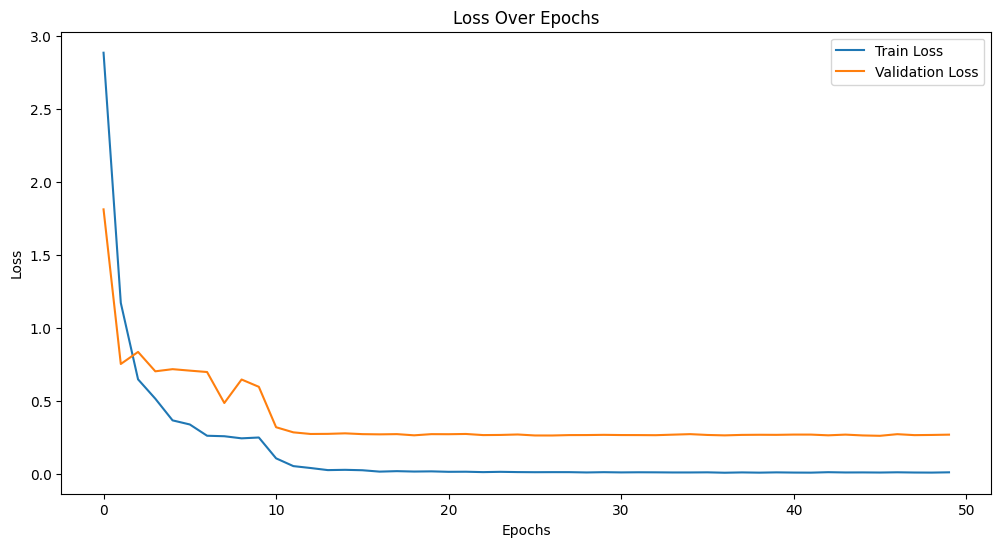

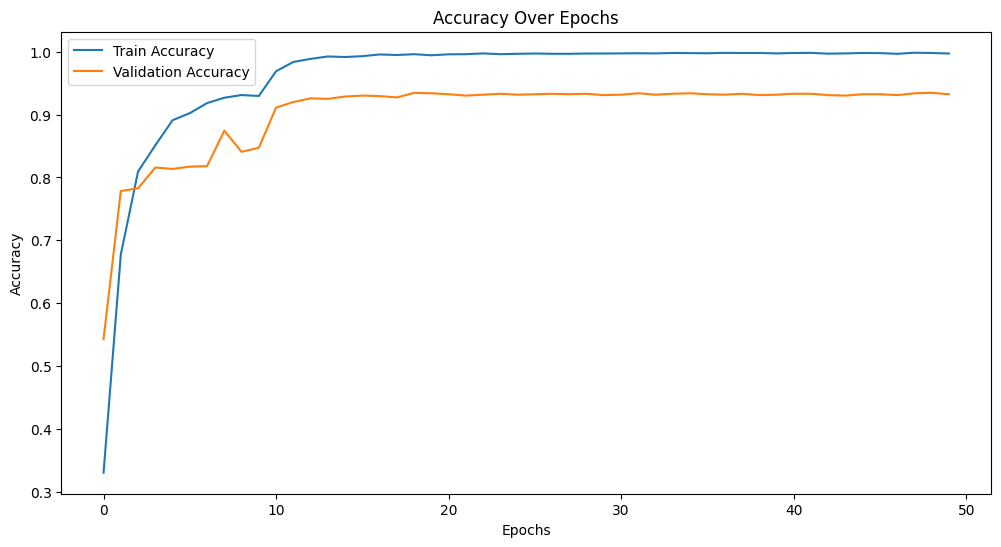

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize lists to store training and evaluation results
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
def train_and_validate(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print('-' * 30)

        # Training
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

        # Validation
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Scheduler step
        scheduler.step()

    # Visualize training results
    plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)

# Visualization function
def plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies):
    # Loss graph
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Accuracy graph
    plt.figure(figsize=(12, 6))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Model training and validation
num_epochs = 50
train_and_validate(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs)

# test imege with real data, not in dataset

Resized size: (300, 300, 3)


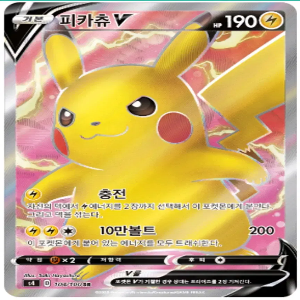


Predicted Class: Pikachu


In [ ]:
from PIL import Image
import torch
from torchvision import transforms
import cv2
from google.colab.patches import cv2_imshow

# Path to the test image
test_image_path = "/content/pikachu.jpg"  # Path to the test image file

img = cv2.imread(test_image_path)
# cv2_imshow(img)
new_width, new_height = 300, 300  # Desired dimensions
resized_img = cv2.resize(img, (new_width, new_height))

# Check the size of the resized image
print(f"Resized size: {resized_img.shape}")

# Display the resized image
cv2_imshow(resized_img)
plt.show()

# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Adjust size to fit input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the image
image = Image.open(test_image_path).convert("RGB")  # Load image and convert to RGB
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Load the model (should be a pre-trained model)
model.eval()  # Switch to evaluation mode

# Move to GPU
input_tensor = input_tensor.to(device)

# Prediction
with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted = torch.max(outputs, 1)

# Class labels
class_labels = train_dataset.classes  # Automatically generated class labels from ImageFolder

# Output the result
predicted_class = class_labels[predicted.item()]
print(f"\nPredicted Class: {predicted_class}")

In [ ]:
from google.colab import files

# Upload files from your local drive
uploaded = files.upload()